In [15]:
import gc
import math
import itertools

import numpy as np
import pandas as pd
from pprint import pprint as pp

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import scipy.stats as st
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN, OPTICS

import infoStructure as ins
import helpers as hp
import clustering as cl
import display as dp
import importlib #importlib.reload(foo)

> Point to the directories (output for the processed mat files and where the mat files reside

In [2]:
INPUTDir = '/media/valeporti/ADATA SH14/stg/Brest/' # the directory where the all the patients are (RS1000, RS10001...)
OUTPUTDir = '/media/valeporti/ADATA SH14/stg/'
# also, the variables to get from .mat files used all along the study
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange', 'gold', 
                              'tomato', 'crimson', 'darkslategray', 'springgreen', 'chocolate'])
titles = ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'] 
feat_dict = None
df_ALL = None

> Grab all the patients directory that you need, and the specific features from the 34

<span style="color:red">Just needed to extract information. If needed, remove the tripple quotes</span>
```python
""" commented code """
```

> /!\ ATENTION: in the "addAllPatientsInfoV4" script, the most suitable variable for scalable data is to_hdf = True, because it won't saturate RAM, even though, it's bigger than feather in ROM and takes more time on loading. 

> Because of this, the recommended way to do this is to extract [100] patients (as quantities) and since they are taken randomly from the source, this would help, afterwards around 75% from this info should be extracted to do the further calculations

In [ ]:
"""# files to save (of 5, and 10 and 50 ... patients inside)
quantities = [5, 10, 20, 50, 100] #[5, 10, 50, 100, 200] # max num of patients = 524
## randomly
ins.addAllPatientsInfoV4(INPUTDir, titles, quantities, OUTPUTDir, to_hdf=True)
"""

** Grab the information previously treated and saved as a feather file **

In [3]:
name_of_file = '100_f32.h5' #'550_32.feather'

# if the information has been grabed from previous cell (from patients input files)
#df_ALL = hp.convertDictInDF(feat_dict)
df_ALL = hp.readFileToPandas(OUTPUTDir + name_of_file)

reading h5


In [4]:
df_ALL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25243388 entries, 0 to 25243387
Data columns (total 6 columns):
vectorRRKLD       float32
voie_num          uint8
vectorFAmpKLD     float32
vectorUFAmpKLD    float32
vectorCorrKLD     float32
paths             object
dtypes: float32(4), object(1), uint8(1)
memory usage: 794.4+ MB


In [5]:
df_ALL.head()

,vectorRRKLD,voie_num,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD,paths
0,14.223434,0,6.777984,7.056729,0.278745,RS10143/RS10143_150408_102446.mat
1,14.086390,0,5.879048,6.041784,0.162735,RS10143/RS10143_150408_102446.mat
2,13.953464,0,5.964413,6.127149,0.162736,RS10143/RS10143_150408_102446.mat
3,13.829085,0,6.013064,6.120740,0.107676,RS10143/RS10143_150408_102446.mat
4,13.731248,0,6.047493,6.155169,0.107676,RS10143/RS10143_150408_102446.mat


** According to the quantity of the memory available, grab randomly the rows for the study of the data **
> 0.22 (22%) for a 16Go RAM memory avaliable computer, for one model

> 0.16 for a 16Go RAM memory available computer, for running several models (like GMM but several times to get the best BIC score)

In [6]:
df_DIV, indexes = hp.getRandomRows(df_ALL, 0.5)
df_DIV, df_info = hp.cleanDF(df_DIV, ['paths', 'voie_num']) # divide DF between pure info and data

### Preprocessing

In [7]:
df_DIV = cl.cleanData(df_DIV, 'mean') # impute non available data in the columns using a strategy (mean, median, most_frequent)

> Dependign if PCA wants to be applied, run one or the other, in this step, removing outliers and normalization takes place

> Besides, in order to do a hard removal for the difficult "vectorUFAmpKLD" feature removal, choose v3=True for the runOutNormV2, else, if just wanted it to be handled with the meanshift appraoch, use v3=False

In [8]:
df_nout, Xnorm, std, indexes2 = cl.runOutNormV2(df_DIV, indexes, threshold=20, threshold_hard=0.01, v3=True)
## for PCA run this one
#df_nout, Xnorm, Xpca, dfPca, titPca, pca, std, indexes2 = cl.runOutNormPCAV2(df_DIV, indexes, threshold=20, threshold_hard=0.01, cols_hard=[0,2])

bandwidth: 871086780214601.4
number of estimated clusters : 3
shapes: (12621694,), (12621694, 4)
to_maintain_indexes  [ True  True  True ... False  True  True]
after hard removal (vectorUFAmpKLD && vectorRRKLD) shape : (12232744, 4) && 96.92
after soft removal (vectorCorrKLD && vectorFAmpKLD) shape : (12621694, 4) && 100.0


> declare which matrix of data should be used for the models according to the previous choice

In [9]:
X = Xnorm # Xnorm or Xpca

> print data as obtained from preprocessing, 
 ```python
if Xpca, the "titPca" variable should be passed,
else titles of columns should be passed (['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'])
```

In [10]:
#dp.printPCAScatter(df_nout, titles)
del df_nout; gc.collect()
# del dfPca; gc.collect()

0

### Model

```python 
if used v3=False for the preprorcessing step (runOutNormV2 function), components should be around 8 and 10
else components are around 6 and 8
```

In [11]:
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=0).fit(X)
#gmm10 = GaussianMixture(n_components=10, covariance_type='full').fit(X)

In [27]:
gmm_to_print = gmm

predicted = gmm_to_print.predict(X)
representativeness = hp.getRepresentativeness(gmm_to_print, X, predicted)
repre_dict = hp.getObjOfRepresentativeness(representativeness)
pp(repre_dict)

totals: {'>50': 1, '>30': 0, '>15': 1, '>05': 2, '<05': 3}
{0: {'group': 0, 'qty': 8066970, 'representativeness': 0.6594571095414079},
 1: {'group': 1, 'qty': 2148755, 'representativeness': 0.17565600980450502},
 2: {'group': 2, 'qty': 3783, 'representativeness': 0.00030925195524405646},
 3: {'group': 3, 'qty': 446679, 'representativeness': 0.03651502884389635},
 4: {'group': 4, 'qty': 275, 'representativeness': 2.248064702408552e-05},
 5: {'group': 5, 'qty': 942504, 'representativeness': 0.07704763542832255},
 6: {'group': 6, 'qty': 623778, 'representativeness': 0.05099248377960006}}


**<span style="color:red">Extract the desired data from a cluster, complemented with its information</span>**

In [18]:
num_of_samples = 5
cluster = 0
desired_data = hp.getFromClusterInfo(X, predicted, num_of_samples, indexes2, cluster, df_info, titles)
desired_data

,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
14332239,RS10260/RS10260_141223_054321.mat,1,-0.001434,-0.164519,-0.048320,-0.075269
21014133,RS10229/RS10229_150104_231543.mat,1,-0.001434,-0.181842,-0.038491,0.978763
8888518,RS10269/RS10269_141027_110959.mat,1,-0.001434,2.745057,0.422984,-0.369087
6888472,RS10055/RS10055_160810_130929.mat,0,-0.001434,-0.172541,-0.036840,0.989810
16967929,RS10060/RS10060_170224_112409.mat,1,-0.001434,-0.161154,-0.048341,-0.122790


**<span style="color:red">Get the N samples of points "around" each of the calculated centers (mean of each mixture component</span>**

In [31]:
num_of_samples = 5
for c, cluster_center in enumerate(gmm_to_print.means_):
  print(f'cluster group ({c}), representativity: { round(repre_dict[c]["representativeness"] * 100, 2) }%, center_vector_values: {cluster_center}')
  display(hp.getFromNearestInfo(cluster_center, X, num_of_samples, indexes2, df_info, titles))

cluster group (0), representativity: 65.95%, center_vector_values: [-0.00143433 -0.16901911 -0.0511844  -0.25253764]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
18044516,RS10311/RS10311_170703_100552.mat,1,-0.001434,-0.164519,-0.048320,-0.075269
18044515,RS10311/RS10311_170703_100552.mat,1,-0.001434,-0.181842,-0.038491,0.978763
6248966,RS10444/RS10444_181112_110610.mat,0,-0.001434,2.745057,0.422984,-0.369087
13238436,RS10022/RS10022_170330_114711.mat,2,-0.001434,-0.172541,-0.036840,0.989810
9325123,RS10250/RS10250_160711_114741.mat,1,-0.001434,-0.161154,-0.048341,-0.122790


cluster group (1), representativity: 17.57%, center_vector_values: [-0.00143387 -0.13799248 -0.03169724  0.94859809]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
24884240,RS10163/RS10163_150124_171646.mat,2,-0.001434,-0.164519,-0.048320,-0.075269
16386095,RS10221/RS10221_140523_131742.mat,2,-0.001434,-0.181842,-0.038491,0.978763
16122599,RS10221/RS10221_140523_091742.mat,2,-0.001434,2.745057,0.422984,-0.369087
8065719,RS10255/RS10255_161208_093137.mat,0,-0.001434,-0.172541,-0.036840,0.989810
8065720,RS10255/RS10255_161208_093137.mat,0,-0.001434,-0.161154,-0.048341,-0.122790


cluster group (2), representativity: 0.03%, center_vector_values: [-1.43433275e-03  7.00894871e+00  5.58586790e+01  3.57958245e-01]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
21543934,RS10229/RS10229_150105_071543.mat,2,-0.001434,-0.164519,-0.048320,-0.075269
21544427,RS10229/RS10229_150105_071543.mat,2,-0.001434,-0.181842,-0.038491,0.978763
21542094,RS10229/RS10229_150105_071543.mat,2,-0.001434,2.745057,0.422984,-0.369087
21537865,RS10229/RS10229_150105_071543.mat,2,-0.001434,-0.172541,-0.036840,0.989810
21540678,RS10229/RS10229_150105_071543.mat,2,-0.001434,-0.161154,-0.048341,-0.122790


cluster group (3), representativity: 3.65%, center_vector_values: [-1.43433270e-03  3.17094700e+00  6.04354032e-01  6.02638103e-01]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
8514606,RS10003/RS10003_170119_135122.mat,1,-0.001434,-0.164519,-0.048320,-0.075269
7839841,RS10322/RS10322_171122_142018.mat,1,-0.001434,-0.181842,-0.038491,0.978763
8515098,RS10003/RS10003_170119_135122.mat,1,-0.001434,2.745057,0.422984,-0.369087
7839838,RS10322/RS10322_171122_142018.mat,1,-0.001434,-0.172541,-0.036840,0.989810
9838702,RS10064/RS10064_170118_095218.mat,1,-0.001434,-0.161154,-0.048341,-0.122790


cluster group (4), representativity: 0.0%, center_vector_values: [ 6.37955816e+01  5.00727161e-03 -2.42971331e-02 -3.89879906e-01]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
19046862,RS10329/RS10329_170720_095227.mat,1,-0.001434,-0.164519,-0.048320,-0.075269
19046861,RS10329/RS10329_170720_095227.mat,1,-0.001434,-0.181842,-0.038491,0.978763
20093031,RS10424/RS10424_190319_123154.mat,0,-0.001434,2.745057,0.422984,-0.369087
23203441,RS10286/RS10286_161116_113748.mat,0,-0.001434,-0.172541,-0.036840,0.989810
20089549,RS10424/RS10424_190319_123154.mat,0,-0.001434,-0.161154,-0.048341,-0.122790


cluster group (5), representativity: 7.7%, center_vector_values: [-0.00143433 -0.16331883 -0.0497905  -0.17447417]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
22649732,RS10426/RS10426_190315_103816.mat,1,-0.001434,-0.164519,-0.048320,-0.075269
12240430,RS10337/RS10337_170927_105706.mat,2,-0.001434,-0.181842,-0.038491,0.978763
7463004,RS10164/RS10164_141228_213128.mat,1,-0.001434,2.745057,0.422984,-0.369087
4669275,RS10523/RS10523_190311_150900.mat,0,-0.001434,-0.172541,-0.036840,0.989810
14670735,RS10260/RS10260_141223_094321.mat,2,-0.001434,-0.161154,-0.048341,-0.122790


cluster group (6), representativity: 5.1%, center_vector_values: [-0.00143433  0.47039807  0.05092837 -0.43717912]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
16871971,RS10060/RS10060_170222_140557.mat,2,-0.001434,-0.164519,-0.048320,-0.075269
16914247,RS10060/RS10060_170224_112409.mat,0,-0.001434,-0.181842,-0.038491,0.978763
115249,RS10143/RS10143_150408_102446.mat,1,-0.001434,2.745057,0.422984,-0.369087
119790,RS10143/RS10143_150408_102446.mat,1,-0.001434,-0.172541,-0.036840,0.989810
863622,RS10143/RS10143_150408_182446.mat,2,-0.001434,-0.161154,-0.048341,-0.122790


> ** TO PRINT**

```python
# for 2d prinring of all clusters together (6 images), use: 
dp.printPCAGMM(gmm_to_print, X, titles, color_iter)
# for 2d printing of one cluster, use next: 
# ( gmm, gmm.predict(X), cluster #, column_1_to_display, column_2_to_display, color_of_cluster, titles )
fig, ax = plt.subplots(1, 1)
dp.plotOneGMMCluster(ax, X, predicted, 0, 0, 1, 'turquoise', titles)
# for 3d printing of onw cluster, use next: 
# ( 3dfig, gmm, gmm.predict(X), cluster #, column_1_to_display, column_2_to_display, column_3_to_display, color_of_cluster, titles)
ax = plt.axes(projection='3d') # just once!!
dp.plotOneGMMCluster3D(ax, X, predicted, 2, 0, 1, 2, 'turquoise', titles)
# to print all 6 possible combinations 
dp.plotAll2DGMMs(X, predicted, 1, 'turquoise', titles)
```

> <span style="color:red">put one plot by cell, if not, dynamic display wont appear for each plot</span>

** For each cluster, and for different features, the next cell chould be modified taking into accunt the variables mentioned above ** 

*Since just one cluster colored by 2 cells considering 4 dimensions, 2 plots must be donne to show each cluster according the 4 dimensions in a 3d plot*

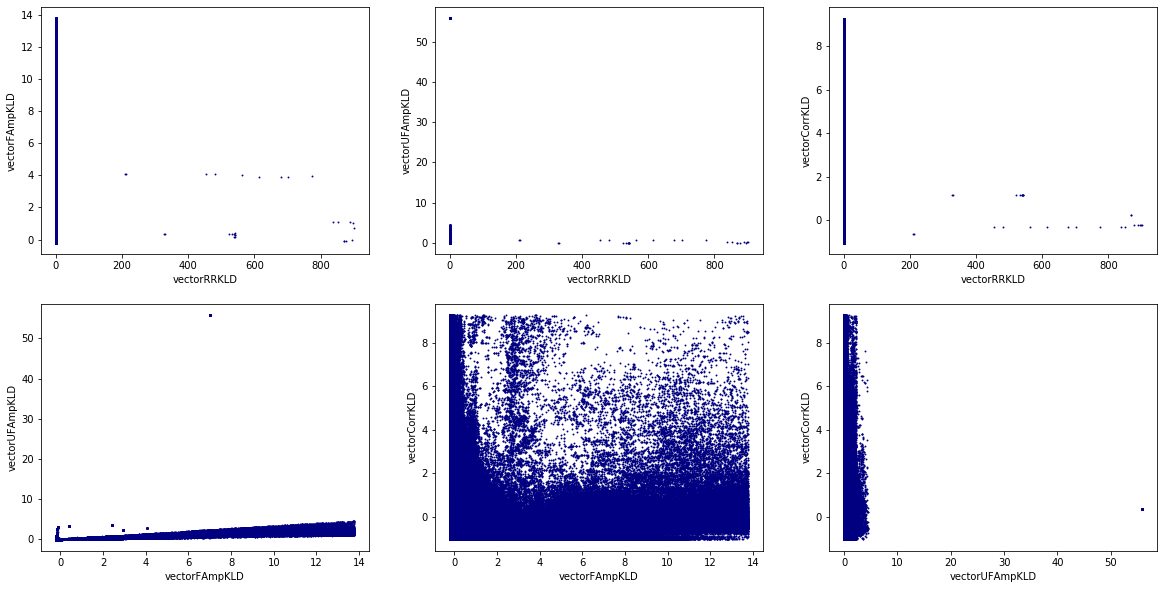

In [32]:
%matplotlib inline 
dp.plotAll2DGMMs(X, predicted, 0, 'red', titles)

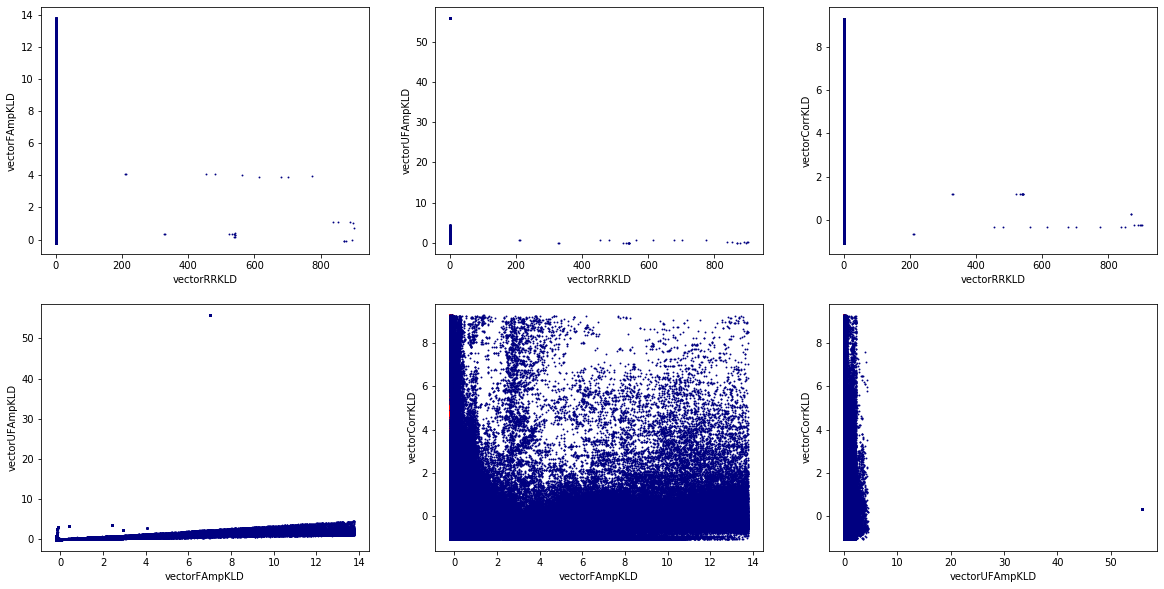

In [33]:
%matplotlib inline 
dp.plotAll2DGMMs(X, predicted, 1, 'red', titles)

----------------------------------------------------
<span style="color:red">Ignore Displayed plots, they have nothing to do with previus calculations meaning that they have been produced with other data, they haven't been run recently</span>

----------------------------------------------------

### 3D MANIPULATION

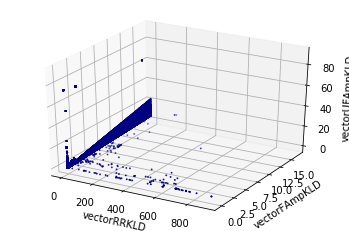

6091

In [20]:
# to show a dinamic view "%matplotlib notebook" , if not desired, use "%matplotlib inline"
%matplotlib inline 
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 0, 0, 1, 2, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

<IPython.core.display.Javascript object>


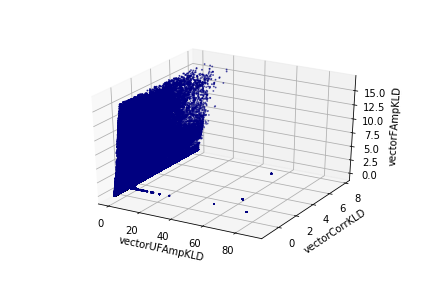

In [19]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 0, 2, 3, 1, 'red', titles)
plt.show(); #plt.clf(); plt.close(); gc.collect()

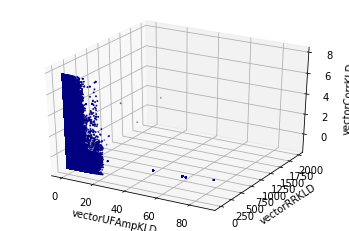

3061

In [35]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 1, 2, 0, 3, 'red', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

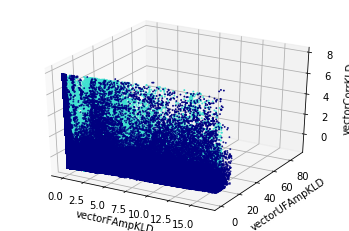

3293

In [24]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 2, 1, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

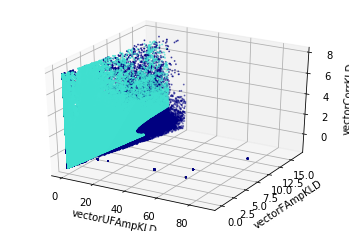

5621

In [29]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 2, 2, 1, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

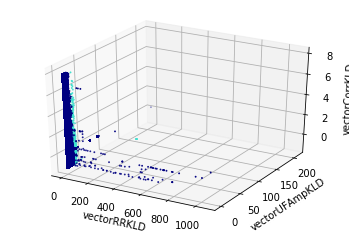

In [15]:
# to show a dinamic view "%matplotlib notebook" , if not desired, use "%matplotlib inline"
%matplotlib inline 
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 3, 0, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

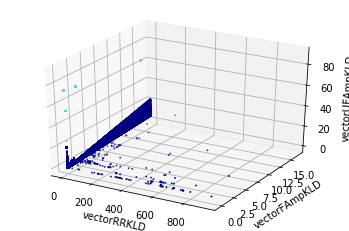

In [17]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 4, 0, 1, 2, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

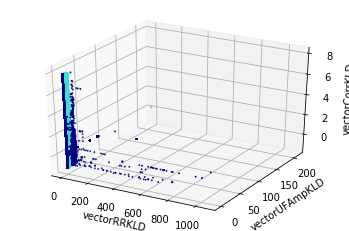

In [16]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 5, 0, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

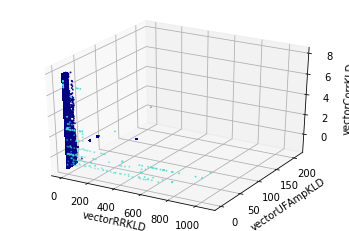

In [17]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 6, 0, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

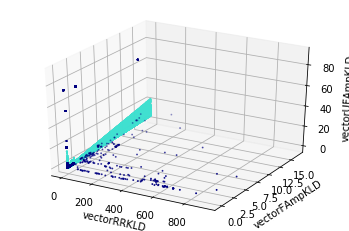

In [17]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 1, 0, 1, 2, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

### Understand de BIC (Bayesian Information Criterion) Optional
> If runned, take into account the percentage of data from the total, for a 16Go computer it will only support 15% og the 120 million rows with 4 features in float32

In [ ]:
"""
n_components_range = range(5, 12)
best_gmm, bic, cv_types = cl.getBestGMMUsingBIC(X, n_components_range, ['full'], 0.1)
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange', 'gold', 'tomato', 'crimson', 'darkslategray', 'springgreen', 'chocolate'])
dp.plotBICScores(bic, cv_types, color_iter, n_components_range)
"""